In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from utils.utils import *

In [2]:
G = ox.load_graphml("data/osmnx/graph.graphml")

In [3]:
graph_nodes, graph_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# Match GPS data to map

In [4]:
public_gps_df = pd.read_csv("data/public/public_gps_traces_bbox.csv")

In [5]:
nearest_edges, dists = ox.nearest_edges(G, public_gps_df["longitude"], public_gps_df["latitude"], return_dist=True, interpolate=metres_to_dist(5))

In [6]:
public_gps_df["ne"] = nearest_edges
public_gps_df["dist"] = dists

In [7]:
matched_public_gps_df = threshold_on_col(public_gps_df)

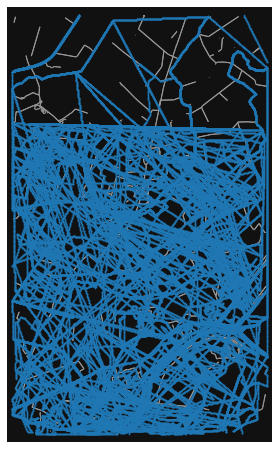

In [8]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(public_gps_df["longitude"], public_gps_df["latitude"], s=2, marker='.')
plt.show()

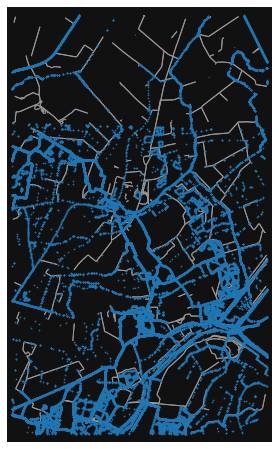

In [9]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(public_gps_df["longitude"], public_gps_df["latitude"], s=2, marker='.')
plt.show()

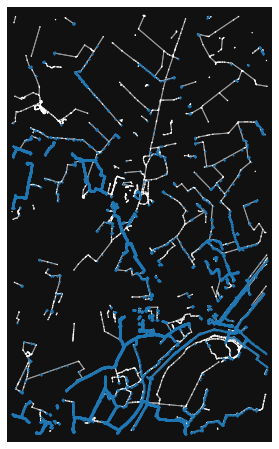

In [7]:
fig, ax = ox.plot_graph(G, node_size=2, show=False, close=False)
ax.scatter(matched_public_gps_df["longitude"], matched_public_gps_df["latitude"], s=2, marker='.')
plt.show()

In [94]:
matched_graph_edges_public = match_nearest_edges(graph_edges, matched_public_gps_df["ne"])

In [95]:
max_point_separation = 30

In [96]:
matched_graph_edges_public = matched_graph_edges_public.assign(activity=matched_graph_edges_public["count"] / matched_graph_edges_public["length"])

In [97]:
matched_graph_edges_public = matched_graph_edges_public.loc[matched_graph_edges_public["activity"] > 1/max_point_separation]

In [98]:
matched_graph_edges_public.to_file("analysis_saves/matched_graph_edges_public.shp")

In [99]:
G_match_public = ox.graph_from_gdfs(graph_nodes, matched_graph_edges_public)

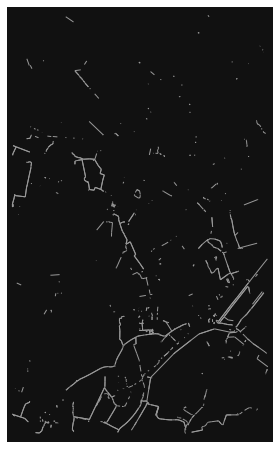

In [100]:
fig, ax = ox.plot_graph(G_match_public, node_size=0)

# Match ROW data to map

In [13]:
row_df = pd.read_csv("data/row/row_bbox.csv")

In [14]:
nearest_edges, dists = ox.nearest_edges(G, row_df["longitude"], row_df["latitude"], return_dist=True, interpolate=metres_to_dist(5))

In [15]:
row_df["ne"] = nearest_edges
row_df["dist"] = dists

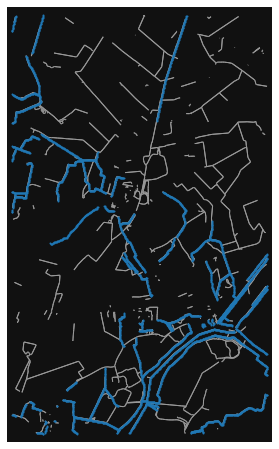

In [18]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(row_df["longitude"], row_df["latitude"], s=4, marker='.')
plt.show()

In [16]:
matched_row_df = threshold_on_col(row_df)

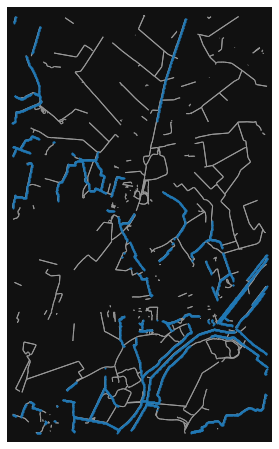

In [20]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.scatter(matched_row_df["longitude"], matched_row_df["latitude"], s=4, marker='.')
plt.show()

In [101]:
matched_graph_edges_row = match_nearest_edges(graph_edges, matched_row_df["ne"])

In [102]:
row_max_length_per_point = 3000

In [103]:
matched_graph_edges_row = matched_graph_edges_row.assign(row=matched_graph_edges_row["length"] / matched_graph_edges_row["count"] < row_max_length_per_point)

In [104]:
matched_graph_edges_row = matched_graph_edges_row.loc[matched_graph_edges_row["row"]]

In [105]:
matched_graph_edges_row.to_file("analysis_saves/matched_graph_edges_row.shp")

In [106]:
G_match_row = ox.graph_from_gdfs(graph_nodes, matched_graph_edges_row)

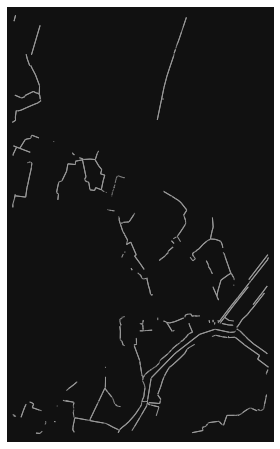

In [107]:
fig, ax = ox.plot_graph(G_match_row, node_size=0)

# Join GPS matched edges and ROW matched edges

In [8]:
matched_graph_edges_public = gpd.read_file("analysis_saves/matched_graph_edges_public.shp").set_index(["u","v","key"])
matched_graph_edges_row    = gpd.read_file("analysis_saves/matched_graph_edges_row.shp"   ).set_index(["u","v","key"])

In [9]:
df1, df2 = merge_on_edges(matched_graph_edges_public, matched_graph_edges_row, hows=["inner", "left_only"], del_cols=["count"])

df1["row"] = df1["row"] == 1
df2["row"] = df2["row"] == 1

import networkx as nx

def clean_graph_edges(nodes, edges):
    _G = ox.graph_from_gdfs(nodes, edges)
    subgraphs = [G.subgraph(c).copy() for c in nx.weakly_connected_components(G)]
    recon = nx.disjoint_union_all(subgraphs)
    return ox.graph_to_gdfs(recon, nodes=True, edges=True)

_, df2_clean = clean_graph_edges(graph_nodes, df2)

In [10]:
public_row_df = pd.concat([df1, df2], axis=0)

In [11]:
public_row_df = public_row_df.astype(graph_edges.dtypes.to_dict())

In [12]:
public_row_df["activity"] = np.clip(public_row_df["activity"], 0, 10) * 10

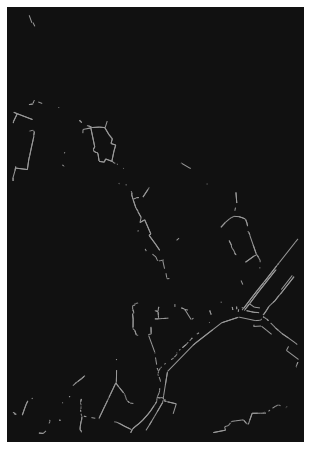

In [53]:
fig, ax = ox.plot_graph(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == True]), node_size=0)

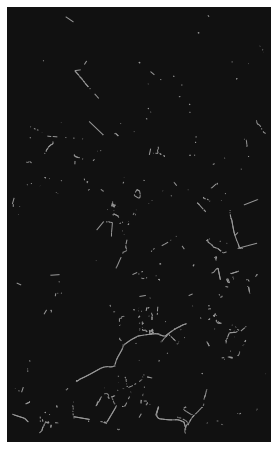

In [54]:
fig, ax = ox.plot_graph(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == False]), node_size=0)

In [55]:
ox.save_graphml(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == True]),  "output/G_busyrow.graphml")
ox.save_graphml(ox.graph_from_gdfs(graph_nodes, public_row_df[public_row_df["row"] == False]), "output/G_busynonrow.graphml")

In [131]:
def _thresh(x,t): return x[x<t]

(array([468., 126.,  59.,  24.,  11.,   9.,   3.,   4.,   0.,   1.]),
 array([0.03409072, 0.45687707, 0.87966342, 1.30244978, 1.72523613,
        2.14802249, 2.57080884, 2.9935952 , 3.41638155, 3.83916791,
        4.26195426]),
 <BarContainer object of 10 artists>)

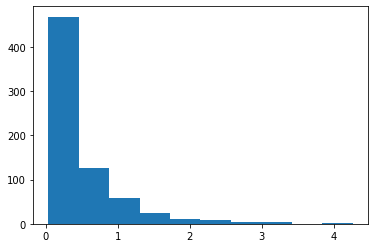

In [133]:
plt.hist(_thresh(df1["activity"].to_numpy(), 5))

(array([1049.,  228.,   82.,   29.,   17.,   10.,    8.,    6.,    2.,
           2.]),
 array([0.03341732, 0.52880333, 1.02418933, 1.51957533, 2.01496133,
        2.51034734, 3.00573334, 3.50111934, 3.99650535, 4.49189135,
        4.98727735]),
 <BarContainer object of 10 artists>)

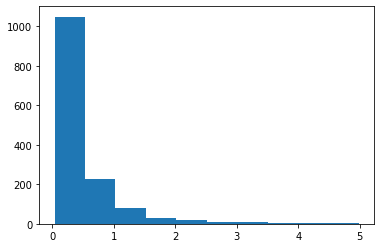

In [134]:
plt.hist(_thresh(df2["activity"].to_numpy(), 5))

In [ ]:
ox.plot_graph_folium(G)

In [ ]:
nodes, edges = ox.graph_to_gdfs(G, fill_edge_geometry=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
nodes.plot(ax=ax, facecolor='black')
edges.plot(ax=ax, facecolor='black')

In [54]:
dists = np.array(dists)

(array([12532.,  8973.,  6451.,  4529.,  3814.,  2958.,  2417.,  2060.,
         1832.,  1549.]),
 array([2.93381020e-02, 1.00247973e+01, 2.00202564e+01, 3.00157156e+01,
        4.00111748e+01, 5.00066339e+01, 6.00020931e+01, 6.99975522e+01,
        7.99930114e+01, 8.99884706e+01, 9.99839297e+01]),
 <BarContainer object of 10 artists>)

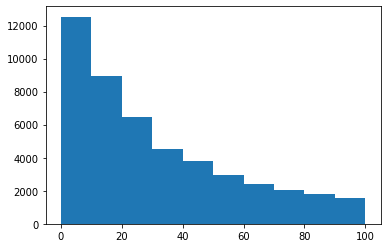

In [55]:
plt.hist(dists[dists<100])